In [1]:
from simulation import Simulation
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Setup simulation object for loading data
sim = Simulation()

In [3]:
# Function for data loading
def load_data(folder_path):
    confinement_time_data = {}
    file_list = os.listdir(folder_path)
    file_list.remove("settings.json")
    for file in file_list:
        sim.load_data(folder_path, file.replace(".pkl", ""))
        confinement_time_data[file.replace(".pkl", "")] = sim.data["confinement_times"]
    return confinement_time_data

In [4]:
# Function for data processing
def process_data(confinement_time_data, simulation_time, deut_only=False):
    # Load Data into Dataframe
    if deut_only:
        confinement_time_df = pd.DataFrame(confinement_time_data, index=["Deuterium"]*10).transpose()
    else:
        confinement_time_df = pd.DataFrame(confinement_time_data, index=["Deuterium"]*5+["Electron"]*5).transpose()
    # Create MultiIndex
    indices = pd.Series(list(confinement_time_data.keys())).str.rsplit("_", 1)
    indices_df = pd.DataFrame(item for item in indices)
    new_index = pd.MultiIndex.from_frame(indices_df, names=['Variable', 'Value'])
    new_index = new_index.set_levels(new_index.levels[-1].astype(float), level=-1)
    # Set new index
    confinement_time_df.index = new_index
    confinement_time_df = confinement_time_df.sort_index()
    # Substituting values corresponding to not escaping confinement to 3*simulation_time
    confinement_time_df = confinement_time_df.replace(False, 3*simulation_time)
    # Create average value columns
    if deut_only:
        confinement_time_df.insert(10, "Deuterium Average Confinement Time (s)", confinement_time_df[["Deuterium",]].mean(axis=1))
    else:
        confinement_time_df.insert(5, "Deuterium Average Confinement Time (s)", confinement_time_df[["Deuterium",]].mean(axis=1))
        confinement_time_df.insert(11, "Electron Average Confinement Time (s)", confinement_time_df[["Electron",]].mean(axis=1))
    return confinement_time_df

In [5]:
# Function for plotting confinement time vs variables
def plot_confinement_time_vs_variables(processed_df, figure_dimensions=(15,15), deut_only=False):
    means_headers = ["Deuterium Average Confinement Time (s)", "Electron Average Confinement Time (s)"]
    variables = processed_df.index.get_level_values(0).unique()
    variable_plot_data = {}
    axis_units = {
        "coil_num" : "",
        "ion_density" : "(m^-3)",
        "temperature" : "(K)",
        "speed" : "(m/s)",
        "E_field" : "(N/C)"
    }
    for variable in variables:
        variable_plot_data[variable] = {}
        variable_plot_data[variable] = {
            "vals" : processed_df.loc[[variable]].index.get_level_values(1) ,
            "deut_confinement_times" : processed_df.loc[[variable]][means_headers[0]],
            "deut_title" : "Avg deuterium confinement time vs " + variable,
            "xlabel" : variable + axis_units[variable] 
        }
        if not deut_only:
            variable_plot_data[variable].update({
                "elec_confinement_times" : processed_df.loc[[variable]][means_headers[1]],
                "elec_title" : "Avg electron confinement time vs " + variable,
            })

    fig=plt.figure(figsize=figure_dimensions)
    counter = 1
    if deut_only:
        for data in variable_plot_data.values():
            plt.subplot(3,1,counter)
            plt.plot(data["vals"], data["deut_confinement_times"], "o")
            plt.title(data["deut_title"])
            plt.xlabel(data["xlabel"])
            plt.ylabel("Confinement time(s)")
            counter += 1
    else:
        for data in variable_plot_data.values():
            plt.subplot(3,2,counter)
            plt.plot(data["vals"], data["deut_confinement_times"], "o")
            plt.title(data["deut_title"])
            plt.xlabel(data["xlabel"])
            plt.ylabel("Confinement time(s)")
            counter += 1
            plt.subplot(3,2,counter)
            plt.plot(data["vals"], data["elec_confinement_times"], "o")
            plt.title(data["elec_title"])
            plt.xlabel(data["xlabel"])
            plt.ylabel("Confinement time(s)")
            counter += 1
    plt.show()

In [6]:
# Function for variable - confinement time correlation generation
def generate_correlation(processed_df, deut_only=False):
    means_headers = ["Deuterium Average Confinement Time (s)", "Electron Average Confinement Time (s)"]
    variables = processed_df.index.get_level_values(0).unique()
    if deut_only:
        correlations = {means_headers[0]: [],}
    else:
        correlations = {means_headers[0]: [], means_headers[1]: []}
    for variable in variables:
        variable_vals = processed_df.loc[[variable]].index.get_level_values(1).to_series()
        variable_deut_confinement_times = processed_df.loc[[variable]][means_headers[0]]
        correlations[means_headers[0]].append(variable_vals.corr(variable_deut_confinement_times))
        if not deut_only:
            variable_elec_confinement_times = processed_df.loc[[variable]][means_headers[1]]
            correlations[means_headers[1]].append(variable_vals.corr(variable_elec_confinement_times))
    return pd.DataFrame(correlations, index=variables)

In [7]:
# Function for exporting series and dataframes
def export_to_excel(data_variables, filenames, relative_folder_path):
    for ind, data in enumerate(data_variables):
        data.to_excel(os.path.join(relative_folder_path, filenames[ind]+".xlsx"))

# Small Value Tokamak Simulation Analysis

In [8]:
# Print settings
folder_path = os.path.join(os.getcwd(), "Small Value Tokamak Data", "data_1")
with open(os.path.join(folder_path, "settings.json"), "r") as f:
    settings = pd.Series(json.load(f))
settings

coil_num              200
coil_num_step          15
E_field             1e-07
E_field_step        9e-09
speed                   3
speed_step            0.2
simulation_time        10
timestep            0.001
folder             data_1
dtype: object

In [9]:
# Load data
confinement_time_data = load_data(folder_path)

In [10]:
# Process and print data
processed_df = process_data(confinement_time_data, settings["simulation_time"], deut_only=True)
processed_df

Deuterium  Deuterium  Deuterium  Deuterium  Deuterium  \
Variable Value                                                                 
E_field  1.000000e-08      0.395      0.041      0.209      0.282      0.067   
         1.900000e-08      1.620      0.068      0.056      3.999      0.501   
         2.800000e-08      0.094      1.035      0.977      0.177      0.052   
         3.700000e-08      0.664      0.526      0.066      0.276      0.214   
         4.600000e-08      0.727      0.082      0.072      0.499      3.093   
...                          ...        ...        ...        ...        ...   
speed    4.200000e+00      0.050      0.063      0.173      0.196      0.104   
         4.400000e+00      0.079      0.067      0.083      0.096      0.162   
         4.600000e+00      0.185      0.080      0.156      0.324      0.174   
         4.800000e+00      0.148      0.069      0.162      0.093      0.066   
         5.000000e+00      0.078      0.201      0.262      0.044      0.218   

                       Deuterium  Deuterium  Deuterium  Deuterium  Deuterium  \
Variable Value                                                                 
E_field  1.000000e-08      0.049      0.189      0.094      0.731      0.223   
         1.900000e-08      0.572      0.943      0.428      0.275      0.326   
         2.800000e-08      0.057      0.077      0.396      0.455      0.247   
         3.700000e-08      0.226      1.561      0.233      0.654      0.496   
         4.600000e-08      0.488      0.317      0.293      0.201      0.327   
...                          ...        ...        ...        ...        ...   
speed    4.200000e+00      0.770      1.245      0.474      0.178      0.227   
         4.400000e+00      0.064      0.048      0.161      0.180      0.077   
         4.600000e+00      0.400      0.810      0.081      0.193      0.221   
         4.800000e+00      0.074      0.109      0.061      0.049      0.070   
         5.000000e+00      0.100      0.176      0.026      0.026      0.074   

                       Deuterium Average Confinement Time (s)  
Variable Value                                                 
E_field  1.000000e-08                                  0.2280  
         1.900000e-08                                  0.8788  
         2.800000e-08                                  0.3567  
         3.700000e-08                                  0.4916  
         4.600000e-08                                  0.6099  
...                                                       ...  
speed    4.200000e+00                                  0.3480  
         4.400000e+00                                  0.1017  
         4.600000e+00                                  0.2624  
         4.800000e+00                                  0.0901  
         5.000000e+00                                  0.1205  

[63 rows x 11 columns]

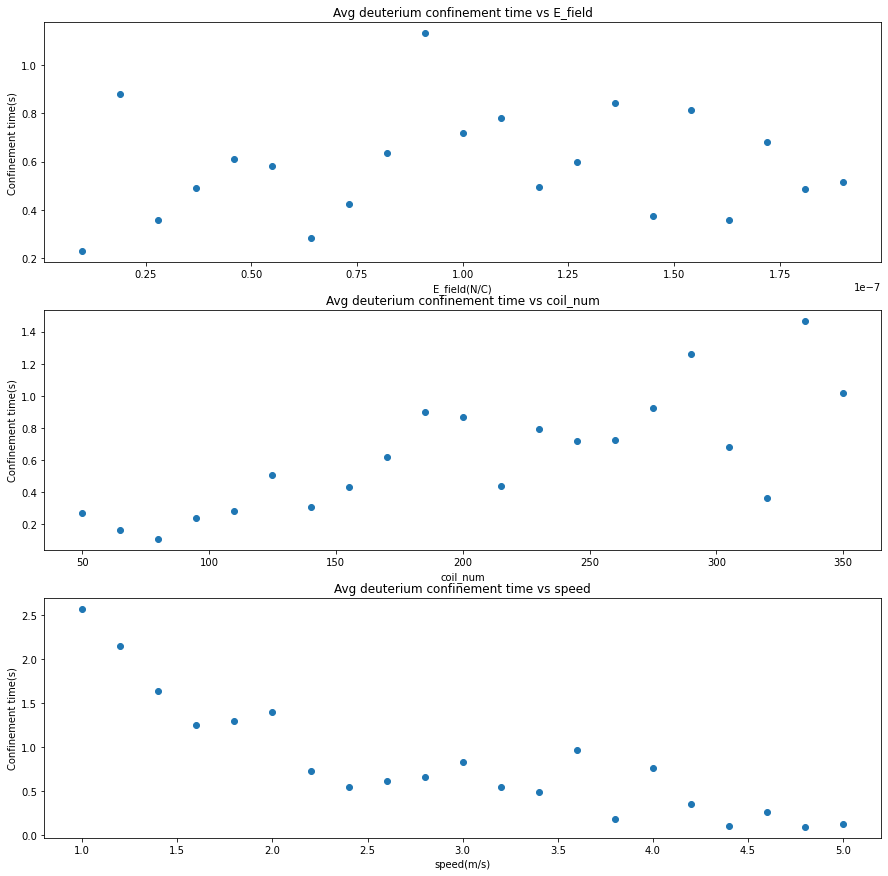

In [11]:
# Plot data
%matplotlib inline
plot_confinement_time_vs_variables(processed_df, deut_only=True)

In [12]:
# Compute confinement time correlations with variables
correlation_df = generate_correlation(processed_df, deut_only=True)
correlation_df

,Deuterium Average Confinement Time (s)
Variable,
E_field,0.119114
coil_num,0.766407
speed,-0.863808


In [13]:
# Export all files to excel
export_to_excel((settings, processed_df, correlation_df), ["small_value_tokamak" + string for string in ["settings", "processed_df", "correlation_df"]], "Processed Data in Excel Format")

# Small Value Tokamak With Stronger Magnetic Field Simulation Analysis

In [14]:
# Print settings
folder_path = os.path.join(os.getcwd(), "Small Value Tokamak Data", "data_stronger_magnetic_field")
with open(os.path.join(folder_path, "settings.json"), "r") as f:
    settings = pd.Series(json.load(f))
settings

coil_num                                   2000
coil_num_step                               150
E_field                                   1e-07
E_field_step                              9e-09
speed                                         3
speed_step                                  0.2
simulation_time                              10
timestep                                  0.001
folder             data_stronger_magnetic_field
dtype: object

In [15]:
# Load data
confinement_time_data = load_data(folder_path)

In [16]:
# Process and print data
processed_df = process_data(confinement_time_data, settings["simulation_time"], deut_only=True)
processed_df

Deuterium  Deuterium  Deuterium  Deuterium  Deuterium  \
Variable Value                                                                 
E_field  1.000000e-08      1.494      3.082      2.367      1.921      2.151   
         1.900000e-08      3.058      1.828      3.995     30.000      1.749   
         2.800000e-08      2.230      1.975      2.116      4.761     30.000   
         3.700000e-08      1.914      3.233      7.631      3.745      2.686   
         4.600000e-08      4.045      4.504      4.585      4.352      2.208   
...                          ...        ...        ...        ...        ...   
speed    4.200000e+00      7.909      1.973      1.646      0.678      3.942   
         4.400000e+00      2.810      2.078      0.620      1.072      1.712   
         4.600000e+00     30.000      2.462      5.239      0.917      0.959   
         4.800000e+00      3.766      0.460      1.217      1.678      1.556   
         5.000000e+00      2.254      6.689      2.021      1.764      3.368   

                       Deuterium  Deuterium  Deuterium  Deuterium  Deuterium  \
Variable Value                                                                 
E_field  1.000000e-08     30.000      2.776      5.709     30.000     30.000   
         1.900000e-08      9.345     30.000      3.515      3.876      8.700   
         2.800000e-08     30.000      3.158     30.000      6.556      2.636   
         3.700000e-08     30.000      1.010      6.888      0.936     30.000   
         4.600000e-08      2.334      0.851     30.000      4.033      5.773   
...                          ...        ...        ...        ...        ...   
speed    4.200000e+00      3.243      2.281      0.900      0.927      0.872   
         4.400000e+00      3.194      2.037      3.288      0.716     30.000   
         4.600000e+00      1.290      3.470      1.202      1.100      1.667   
         4.800000e+00      4.722      0.785      1.019      6.028      0.494   
         5.000000e+00      9.109      2.260      0.812      0.910      2.036   

                       Deuterium Average Confinement Time (s)  
Variable Value                                                 
E_field  1.000000e-08                                 10.9500  
         1.900000e-08                                  9.6066  
         2.800000e-08                                 11.3432  
         3.700000e-08                                  8.8043  
         4.600000e-08                                  6.2685  
...                                                       ...  
speed    4.200000e+00                                  2.4371  
         4.400000e+00                                  4.7527  
         4.600000e+00                                  4.8306  
         4.800000e+00                                  2.1725  
         5.000000e+00                                  3.1223  

[63 rows x 11 columns]

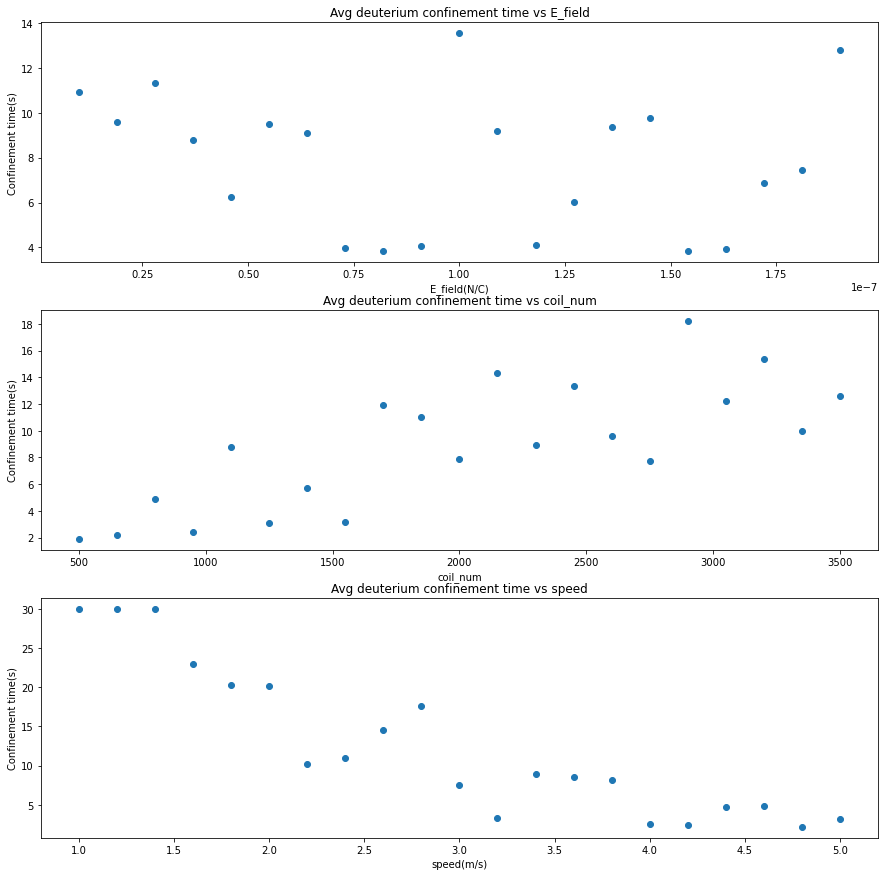

In [17]:
# Plot data
%matplotlib inline
plot_confinement_time_vs_variables(processed_df, deut_only=True)

In [18]:
# Compute confinement time correlations with variables
correlation_df = generate_correlation(processed_df, deut_only=True)
correlation_df

,Deuterium Average Confinement Time (s)
Variable,
E_field,-0.185808
coil_num,0.769680
speed,-0.907227


In [19]:
# Export all files to excel
export_to_excel((settings, processed_df, correlation_df), ["small_value_tokamak_strong_magnetic_field" + string for string in ["settings", "processed_df", "correlation_df"]], "Processed Data in Excel Format")

# ITER Simulation Analysis

In [20]:
# Print settings
folder_path = os.path.join(os.getcwd(), "ITER Tokamak Data", "iter_simulation")
with open(os.path.join(folder_path, "settings.json"), "r") as f:
    settings = pd.Series(json.load(f))
settings

temperature                    100000000
temperature_step                 9000000
coil_num                       100000000
coil_num_step                    9000000
ion_density         10000000000000000000
ion_density_step      900000000000000000
simulation_time                    1e-08
timestep                           2e-12
folder                   iter_simulation
dtype: object

In [21]:
# Load data
confinement_time_data = load_data(folder_path)

In [22]:
# Process and print data
processed_df = process_data(confinement_time_data, settings["simulation_time"])
processed_df

Deuterium     Deuterium     Deuterium  \
Variable    Value                                                   
coil_num    10000000.0   1.038000e-09  1.126000e-09  1.302000e-09   
            19000000.0   9.680000e-10  1.032000e-09  7.820000e-10   
            28000000.0   1.062000e-09  9.340000e-10  1.170000e-09   
            37000000.0   7.800000e-10  1.224000e-09  9.980000e-10   
            46000000.0   7.700000e-10  1.102000e-09  1.220000e-09   
...                               ...           ...           ...   
temperature 154000000.0  1.014000e-09  1.276000e-09  8.840000e-10   
            163000000.0  1.284000e-09  1.164000e-09  1.138000e-09   
            172000000.0  9.480000e-10  1.144000e-09  7.680000e-10   
            181000000.0  9.520000e-10  1.152000e-09  1.130000e-09   
            190000000.0  1.268000e-09  1.158000e-09  1.194000e-09   

                            Deuterium     Deuterium  \
Variable    Value                                     
coil_num    10000000.0   1.094000e-09  1.296000e-09   
            19000000.0   1.236000e-09  1.260000e-09   
            28000000.0   8.240000e-10  9.900000e-10   
            37000000.0   1.246000e-09  1.318000e-09   
            46000000.0   1.228000e-09  1.078000e-09   
...                               ...           ...   
temperature 154000000.0  1.072000e-09  8.720000e-10   
            163000000.0  1.090000e-09  1.320000e-09   
            172000000.0  1.106000e-09  1.260000e-09   
            181000000.0  1.154000e-09  7.920000e-10   
            190000000.0  1.114000e-09  1.012000e-09   

                         Deuterium Average Confinement Time (s)      Electron  \
Variable    Value                                                               
coil_num    10000000.0                             1.171200e-09  2.600000e-11   
            19000000.0                             1.055600e-09  2.400000e-11   
            28000000.0                             9.960000e-10  3.400000e-11   
            37000000.0                             1.113200e-09  4.000000e-11   
            46000000.0                             1.079600e-09  5.000000e-11   
...                                                         ...           ...   
temperature 154000000.0                            1.023600e-09  1.120000e-10   
            163000000.0                            1.199200e-09  1.120000e-10   
            172000000.0                            1.045200e-09  1.120000e-10   
            181000000.0                            1.036000e-09  1.120000e-10   
            190000000.0                            1.149200e-09  1.140000e-10   

                             Electron      Electron      Electron  \
Variable    Value                                                   
coil_num    10000000.0   2.000000e-11  2.000000e-11  1.800000e-11   
            19000000.0   2.400000e-11  2.400000e-11  2.400000e-11   
            28000000.0   3.400000e-11  3.400000e-11  3.400000e-11   
            37000000.0   4.000000e-11  4.000000e-11  4.000000e-11   
            46000000.0   5.000000e-11  5.000000e-11  5.000000e-11   
...                               ...           ...           ...   
temperature 154000000.0  1.120000e-10  1.120000e-10  1.120000e-10   
            163000000.0  1.140000e-10  1.120000e-10  1.120000e-10   
            172000000.0  1.120000e-10  1.120000e-10  1.120000e-10   
            181000000.0  1.120000e-10  1.120000e-10  1.120000e-10   
            190000000.0  1.120000e-10  1.120000e-10  1.120000e-10   

                             Electron  Electron Average Confinement Time (s)  
Variable    Value                                                             
coil_num    10000000.0   1.400000e-11                           1.960000e-11  
            19000000.0   2.400000e-11                           2.400000e-11  
            28000000.0   3.400000e-11                           3.400000e-11  
            37000000.0   4.000000e-11                           4.0

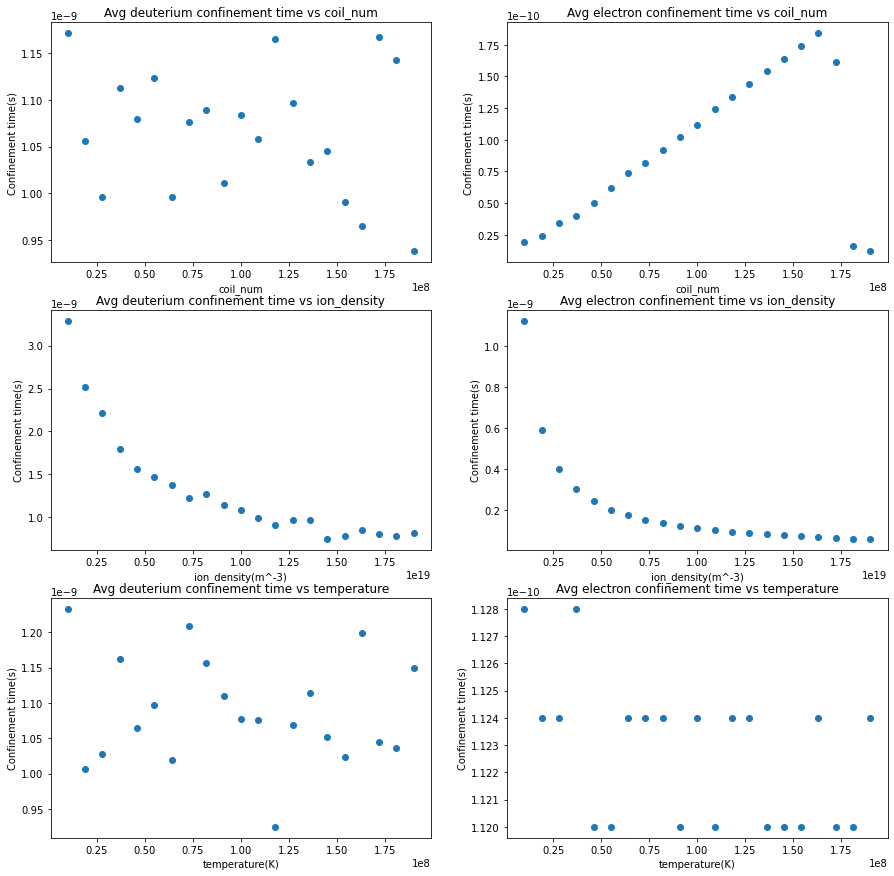

In [23]:
# Plot data
%matplotlib inline
plot_confinement_time_vs_variables(processed_df)

In [24]:
# Compute confinement time correlations with variables
correlation_df = generate_correlation(processed_df)
correlation_df

,Deuterium Average Confinement Time (s),Electron Average Confinement Time (s)
Variable,,
coil_num,-0.205564,0.524500
ion_density,-0.853642,-0.716936
temperature,-0.123836,-0.465171


In [25]:
# Export all files to excel
export_to_excel((settings, processed_df, correlation_df), ["ITER_" + string for string in ["settings", "processed_df", "correlation_df"]], "Processed Data in Excel Format")

# ITER Weak Electric Field Simulation Analysis

In [26]:
# Print settings
folder_path = os.path.join(os.getcwd(), "ITER Tokamak Data", "iter_simulation_weak_E")
with open(os.path.join(folder_path, "settings.json"), "r") as f:
    settings = pd.Series(json.load(f))
settings

temperature                100000000
temperature_step             9000000
coil_num                   100000000
coil_num_step                9000000
ion_density         1000000000000000
ion_density_step      90000000000000
simulation_time                1e-08
timestep                       1e-12
folder               iter_simulation
dtype: object

In [27]:
# Load data
confinement_time_data = load_data(folder_path)

In [28]:
# Process and print data
processed_df = process_data(confinement_time_data, settings["simulation_time"])
processed_df

Deuterium     Deuterium     Deuterium  \
Variable    Value                                                   
coil_num    10000000.0   3.000000e-08  3.000000e-08  3.000000e-08   
            19000000.0   3.000000e-08  3.000000e-08  3.000000e-08   
            28000000.0   3.000000e-08  3.000000e-08  3.000000e-08   
            37000000.0   3.000000e-08  3.000000e-08  3.000000e-08   
            46000000.0   3.000000e-08  3.000000e-08  3.000000e-08   
...                               ...           ...           ...   
temperature 154000000.0  3.000000e-08  3.000000e-08  3.000000e-08   
            163000000.0  3.000000e-08  3.000000e-08  3.000000e-08   
            172000000.0  3.000000e-08  3.000000e-08  3.000000e-08   
            181000000.0  3.000000e-08  3.000000e-08  3.000000e-08   
            190000000.0  3.000000e-08  3.000000e-08  3.000000e-08   

                            Deuterium     Deuterium  \
Variable    Value                                     
coil_num    10000000.0   3.000000e-08  3.000000e-08   
            19000000.0   3.000000e-08  3.000000e-08   
            28000000.0   3.000000e-08  3.000000e-08   
            37000000.0   3.000000e-08  3.000000e-08   
            46000000.0   3.000000e-08  3.000000e-08   
...                               ...           ...   
temperature 154000000.0  3.000000e-08  3.000000e-08   
            163000000.0  3.000000e-08  3.000000e-08   
            172000000.0  3.000000e-08  3.000000e-08   
            181000000.0  3.000000e-08  3.000000e-08   
            190000000.0  3.000000e-08  3.000000e-08   

                         Deuterium Average Confinement Time (s)      Electron  \
Variable    Value                                                               
coil_num    10000000.0                             3.000000e-08  3.000000e-08   
            19000000.0                             3.000000e-08  3.000000e-08   
            28000000.0                             3.000000e-08  3.000000e-08   
            37000000.0                             3.000000e-08  3.000000e-08   
            46000000.0                             3.000000e-08  3.000000e-08   
...                                                         ...           ...   
temperature 154000000.0                            3.000000e-08  3.000000e-08   
            163000000.0                            3.000000e-08  3.000000e-08   
            172000000.0                            3.000000e-08  3.000000e-08   
            181000000.0                            3.000000e-08  3.000000e-08   
            190000000.0                            3.000000e-08  3.000000e-08   

                             Electron      Electron      Electron  \
Variable    Value                                                   
coil_num    10000000.0   3.000000e-08  3.000000e-08  3.000000e-08   
            19000000.0   3.000000e-08  3.000000e-08  3.000000e-08   
            28000000.0   3.000000e-08  3.000000e-08  3.000000e-08   
            37000000.0   3.000000e-08  3.000000e-08  3.000000e-08   
            46000000.0   3.000000e-08  3.000000e-08  3.000000e-08   
...                               ...           ...           ...   
temperature 154000000.0  3.000000e-08  3.000000e-08  3.000000e-08   
            163000000.0  3.000000e-08  3.000000e-08  3.000000e-08   
            172000000.0  3.000000e-08  3.000000e-08  3.000000e-08   
            181000000.0  3.000000e-08  3.000000e-08  3.000000e-08   
            190000000.0  3.000000e-08  3.000000e-08  3.000000e-08   

                             Electron  Electron Average Confinement Time (s)  
Variable    Value                                                             
coil_num    10000000.0   3.000000e-08                           3.000000e-08  
            19000000.0   3.000000e-08                           3.000000e-08  
            28000000.0   3.000000e-08                           3.000000e-08  
            37000000.0   3.000000e-08                           3.0

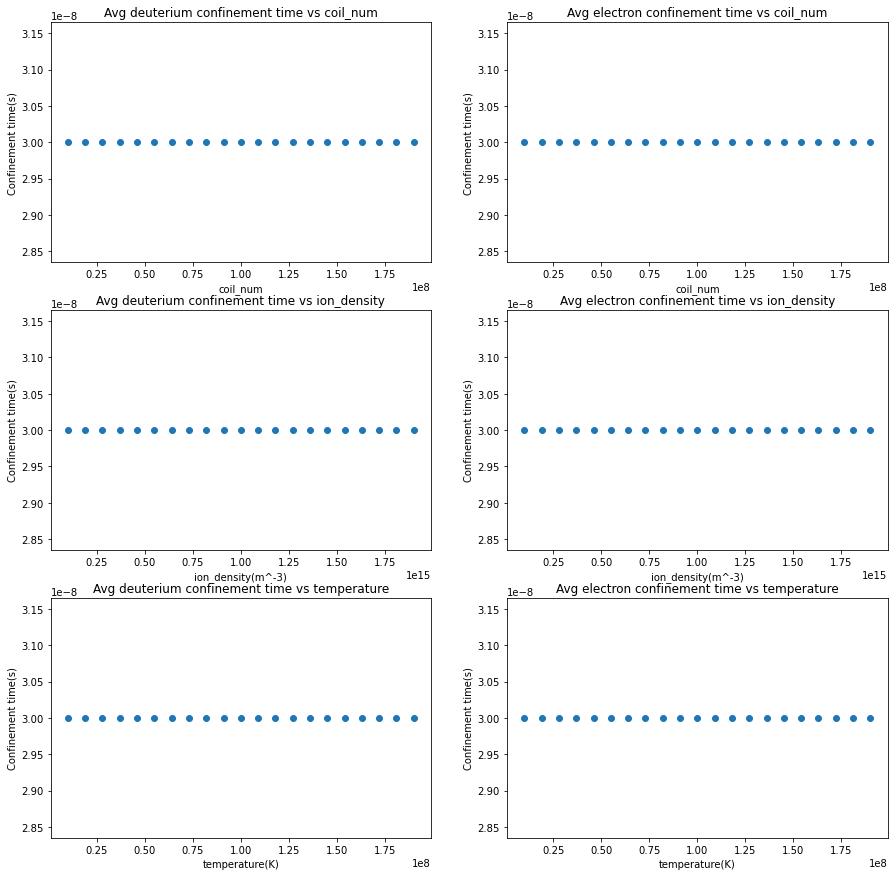

In [29]:
# Plot data
%matplotlib inline
plot_confinement_time_vs_variables(processed_df)

In [30]:
# Compute confinement time correlations with variables
correlation_df = generate_correlation(processed_df)
correlation_df

,Deuterium Average Confinement Time (s),Electron Average Confinement Time (s)
Variable,,
coil_num,0.0,0.0
ion_density,0.0,0.0
temperature,0.0,0.0


In [31]:
# Export all files to excel
export_to_excel((settings, processed_df, correlation_df), ["ITER_weak_E_field" + string for string in ["settings", "processed_df", "correlation_df"]], "Processed Data in Excel Format")